In [1]:
# import required packages
# depending on your environment, you may need to install some of these
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
import rasterio as rio
import datetime as dt
import requests
import pandas as pd
import sys
import contextily as cx
import seaborn as sns

In [ ]:
# ds_list = []
# for ds_path in glob.glob('./data/*.nc'):
#     ds = xr.open_dataset(ds_path)
#     ds = ds.drop_vars('band')
#     ds = ds.drop('s1')
#     ds = ds.transpose('time', 'y', 'x')
#     if ds_list:
#         ds = ds.rio.reproject_match(ds_list[0])
#     ds_list.append(ds)
    
# ds = xr.concat(ds_list, dim='time')

# ds = ds.sortby('time')

# # reproject dataset to utm zone
# crs = ds.rio.estimate_utm_crs()
# ds = ds.rio.reproject(crs)

# # open aoi geojson as geopandas dataframe and reproject
# aoi_fn = './east_river_basin_wgs.geojson'
# aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# # clip dataset to aoi
# ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

# # exclude orbit without full coverage
# ds = ds.where(ds.relative_orbit!=129.0, drop=True)

In [ ]:
# ds.to_netcdf('./data/sd_2016-2022_east-river.nc')

In [2]:
ds = xr.open_dataset('./data/sd_2016-2022_east-river.nc')

In [3]:
crs = ds.rio.estimate_utm_crs()

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './erb_pumphouse_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip dataset to aoi
ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

In [4]:
# function to query SNOTEL api
def get_awdb_data(
    site_ids,
    server,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=dt.datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}/{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

# function to download data for SNOTEL sites within some buffer distance of the site. 
def grab_snotel(aoi_gdf,
                buffer=1000,
                elements=["TAVG","SNWD","WTEQ"]
):
    '''
    Takes a geodataframe containing an area of interest and returns SNOTEL data from 
    stations within some distance of that area of interest. Geodataframe assumed to 
    be projected in appropriate utm zone. 
    '''
    # get SNTL data using an API built by Beau Uriona
    AWDB_API_DOMAIN = "https://api.snowdata.info"

    # pull in metadata for all NRCS SNOTEL sites
    sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
    sntl_gdf = gpd.read_file(sntl_meta_url).to_crs(aoi_gdf.crs)

    # find sites within some distance of aoi
    buf_gdf = aoi_gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    sntl_gdf = gpd.overlay(sntl_gdf, buf_gdf, how='intersection')
    
    # raise error if no site are found
    if sntl_gdf.empty:
        raise Exception(f'No SNOTEL sites within {buffer}m of aoi. Try a larger buffer.') 
    
    # build dict with station names and ids
    site_ids = list(sntl_gdf.stationTriplet)
    
    # download snotel data
    sntl_dfs = get_awdb_data(site_ids, server=AWDB_API_DOMAIN)
    
    # Make the index a datetime
    for i,df in enumerate(sntl_dfs):
        df.index = pd.to_datetime(df.index)
        sntl_dfs[i] = df

    # create a dictionary for conversion to xarray
    sntl_df_dict = {}
    counter = 0
    for i, site in enumerate(site_ids):
        sntl_df_dict[site_ids[i]] = pd.concat(sntl_dfs[counter:counter+len(elements)], 
                                              axis=1).sort_index().to_xarray()
        counter+=len(elements)
    
    # convert to xarray
    sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
    
    return sntl_ds, sntl_gdf

In [ ]:
# # get snotel data
# sntl_ds, sntl_gdf = grab_snotel(aoi_gdf)
# # convert to meters
# sntl_ds['SNWD'] = sntl_ds['SNWD']*0.0254

/mnt/Backups/gbrench/sw/miniconda3/envs/spicy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/Backups/gbrench/sw/miniconda3/envs/spicy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/Backups/gbrench/sw/miniconda3/envs/spicy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, 'AOI snow depth time series')

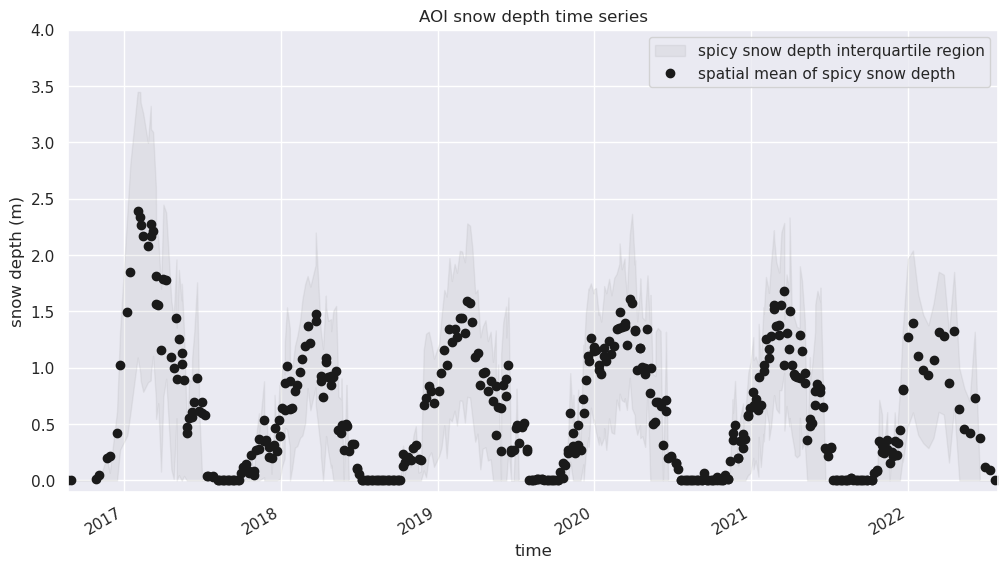

In [5]:
# plot snow depth time series
sns.set_theme()
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').time,
                ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').values,
                ds.snow_depth.quantile(q=0.75, dim=['x', 'y']).dropna('time').values,
                alpha=0.1, color='Grey', label='spicy snow depth interquartile region')
# for site in sntl_ds.Location:
#     sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
ds.snow_depth.mean(dim=['x', 'y']).plot(marker='o', linestyle='', c='k', label='spatial mean of spicy snow depth')
ax.set_xlim(ds.time[0], ds.time[-1])
ax.set_ylim(-0.1, 4)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('AOI snow depth time series')

#plt.savefig('./figs/multi_sd_ts.png', dpi=300)

In [6]:
# load in discharge data (m^3/s)
q_df = pd.read_csv('./All_RF_Wide.csv')[['dateTime', 'Q.PH_ISCO']]
q_df['dateTime'] = pd.to_datetime(q_df['dateTime'])
q_df['water_year'] = q_df.dateTime.dt.year.where(q_df.dateTime.dt.month < 10, q_df.dateTime.dt.year + 1)

In [7]:
# convert discharge data
q_df['m3_perhour'] = q_df['Q.PH_ISCO']*60*60

# accumulate discharge throughout water year
q_df['cum_m3'] = q_df[['water_year', 'm3_perhour']].groupby('water_year').cumsum()

In [8]:
# add water year to ds
ds = ds.assign_coords(water_year = ('time', ds.time.dt.year.where(ds.time.dt.month < 10, ds.time.dt.year + 1).values))

In [17]:
# assume a snow density of 0.3 
w_content = 0.3

ds['total_snow_storage'] = (ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y'])
ds['depth_diff'] = ds.total_snow_storage.diff('time')
ds['depth_diff_rolling'] = ds.total_snow_storage.rolling(time=3).mean().diff('time')

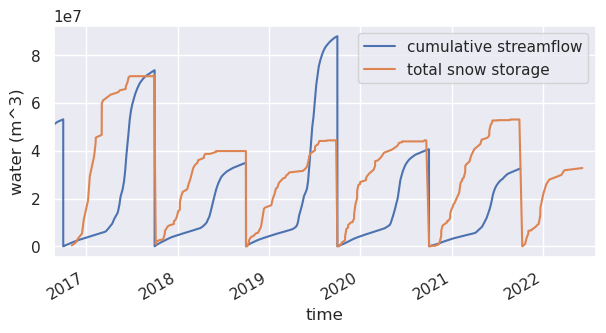

In [29]:
f, ax = plt.subplots(figsize=(7, 3))
ax.plot(q_df['dateTime'], q_df['cum_m3'], label='cumulative streamflow')
ds.depth_diff_rolling.where(ds.depth_diff_rolling >= 0, drop=True).groupby('water_year').cumsum().plot(ax=ax, label='cumulative snowfall')
ax.set_xlim(ds.time[0], ds.time[-1])
ax.set_ylabel('water (m^3)')
ax.set_title('')
ax.legend()